In [27]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [28]:
# Cargar datos
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

# Split (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definir modelos base con hiperparámetros por defecto (baseline)
models = {
    "LogReg": LogisticRegression(max_iter=5000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

# Entrenar y evaluar baseline
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    res = {
        "model": name,
        "train_acc": accuracy_score(y_train, y_pred_train),
        "val_acc": accuracy_score(y_val, y_pred_val),
        "train_f1": f1_score(y_train, y_pred_train),
        "val_f1": f1_score(y_val, y_pred_val)
    }
    results.append(res)

pd.DataFrame(results).set_index("model")


,train_acc,val_acc,train_f1,val_f1
model,,,,
LogReg,0.956044,0.964912,0.965157,0.972603
DecisionTree,1.000000,0.912281,1.000000,0.928571
KNN,0.947253,0.912281,0.958333,0.929577


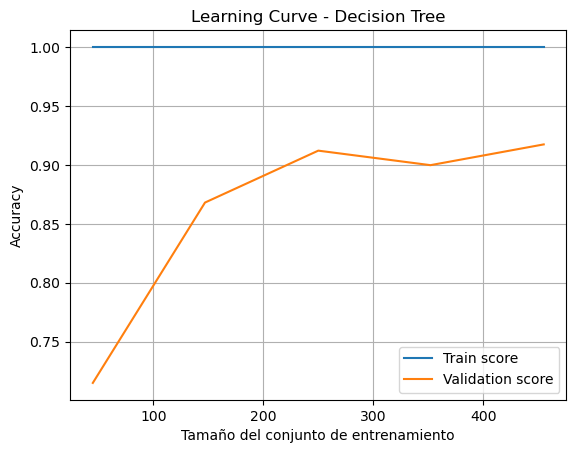

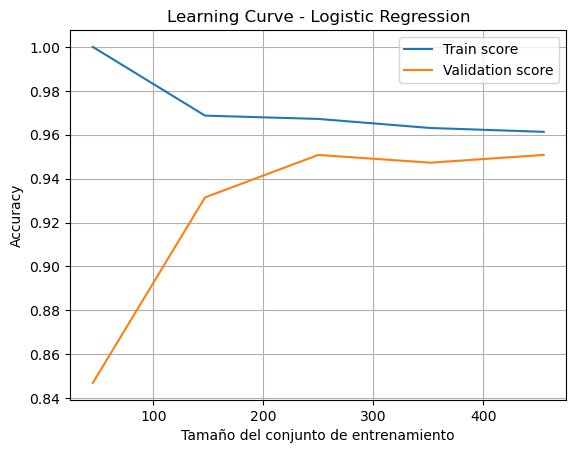

In [29]:
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, n_jobs=-1, scoring='accuracy', random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Train score")
    plt.plot(train_sizes, val_scores_mean, label="Validation score")
    plt.title(title)
    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Decision Tree
plot_learning_curve(DecisionTreeClassifier(random_state=42), "Learning Curve - Decision Tree", X, y, cv=5)

# Logistic Regression
plot_learning_curve(LogisticRegression(max_iter=5000, random_state=42), "Learning Curve - Logistic Regression", X, y, cv=5)


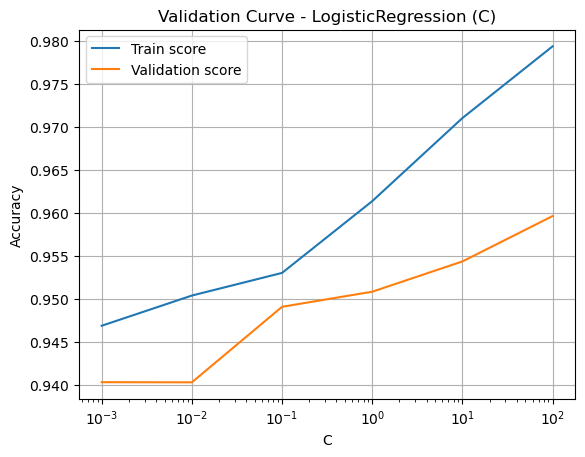

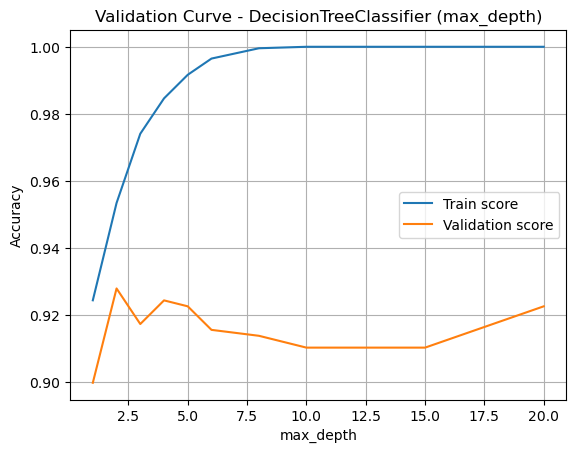

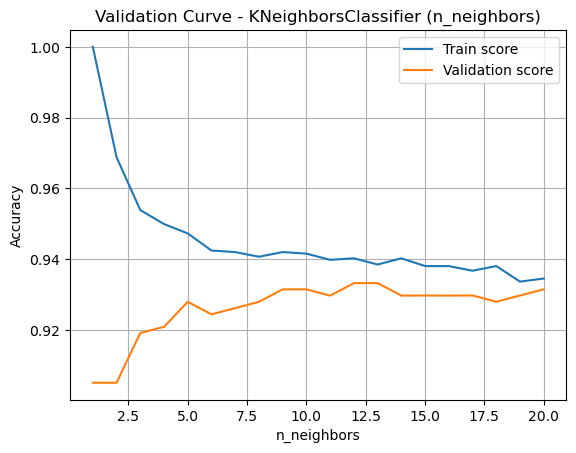

In [30]:
def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring='accuracy'):
    train_scores, val_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    plt.figure()
    plt.plot(param_range, train_mean, label='Train score')
    plt.plot(param_range, val_mean, label='Validation score')
    plt.title(f"Validation Curve - {estimator.__class__.__name__} ({param_name})")
    plt.xlabel(param_name)
    plt.xscale('log' if (min(param_range)>0 and max(param_range)/min(param_range) > 50) else 'linear')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# LogisticRegression: C
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
plot_validation_curve(LogisticRegression(max_iter=5000), X, y, 'C', param_range, cv=5)

# DecisionTree: max_depth
param_range = [1,2,3,4,5,6,8,10,15,20, None]  # None = no limit
# For None the function might fail because of dtype; we remove None for plotting and handle separately:
param_range_tree = [1,2,3,4,5,6,8,10,15,20]
plot_validation_curve(DecisionTreeClassifier(), X, y, 'max_depth', param_range_tree, cv=5)

# KNN: n_neighbors
param_range = list(range(1, 21))
plot_validation_curve(KNeighborsClassifier(), X, y, 'n_neighbors', param_range, cv=5)


In [31]:
best_configs = {
    "LogReg_C0.1": LogisticRegression(C=0.1, max_iter=5000, random_state=42),
    "DecisionTree_d4": DecisionTreeClassifier(max_depth=4, random_state=42),
    "KNN_k7": KNeighborsClassifier(n_neighbors=7)
}

results_tuned = []
for name, model in best_configs.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    results_tuned.append({
        "model": name,
        "train_acc": accuracy_score(y_train, y_pred_train),
        "val_acc": accuracy_score(y_val, y_pred_val),
        "train_f1": f1_score(y_train, y_pred_train),
        "val_f1": f1_score(y_val, y_pred_val)
    })

pd.DataFrame(results_tuned).set_index("model")


,train_acc,val_acc,train_f1,val_f1
model,,,,
LogReg_C0.1,0.953846,0.947368,0.963351,0.958333
DecisionTree_d4,0.986813,0.938596,0.989583,0.951049
KNN_k7,0.947253,0.929825,0.958333,0.944444


In [32]:
# Combinar resultados en una sola tabla (ejemplo simple)
baseline_df = pd.DataFrame(results).set_index("model")
tuned_df = pd.DataFrame(results_tuned).set_index("model")

combined = pd.concat([baseline_df, tuned_df], axis=0).reset_index()
combined


,model,train_acc,val_acc,train_f1,val_f1
0,LogReg,0.956044,0.964912,0.965157,0.972603
1,DecisionTree,1.000000,0.912281,1.000000,0.928571
2,KNN,0.947253,0.912281,0.958333,0.929577
3,LogReg_C0.1,0.953846,0.947368,0.963351,0.958333
4,DecisionTree_d4,0.986813,0.938596,0.989583,0.951049
5,KNN_k7,0.947253,0.929825,0.958333,0.944444


In [33]:
def diagnosis(row, gap_thresh=0.05):
    gap = row['train_acc'] - row['val_acc']
    if row['train_acc'] < 0.7 and row['val_acc'] < 0.7:
        return 'Underfitting'
    if gap > gap_thresh:
        return 'Overfitting'
    return 'Good'

combined['diagnosis'] = combined.apply(diagnosis, axis=1)
combined


,model,train_acc,val_acc,train_f1,val_f1,diagnosis
0,LogReg,0.956044,0.964912,0.965157,0.972603,Good
1,DecisionTree,1.000000,0.912281,1.000000,0.928571,Overfitting
2,KNN,0.947253,0.912281,0.958333,0.929577,Good
3,LogReg_C0.1,0.953846,0.947368,0.963351,0.958333,Good
4,DecisionTree_d4,0.986813,0.938596,0.989583,0.951049,Good
5,KNN_k7,0.947253,0.929825,0.958333,0.944444,Good


# Resumen y Recomendaciones  
### Diagnóstico y Mitigación de Overfitting/Underfitting — Dataset Breast Cancer

---

## 1. Baseline

Se entrenaron tres modelos base: **Logistic Regression**, **Decision Tree** y **KNN**.  
Las métricas iniciales mostraron diferencias claras en su capacidad de generalización:

- Logistic Regression presentó un rendimiento estable y equilibrado.
- Decision Tree sin restricciones mostró **overfitting severo** al alcanzar métricas perfectas en entrenamiento pero significativamente menores en validación.
- KNN mostró un rendimiento adecuado, aunque con ligera variación entre entrenamiento y validación.

Estas métricas iniciales permitieron identificar qué modelos requerían ajustes para mejorar su desempeño.

---

## 2. Diagnóstico con Curvas de Aprendizaje

### **Decision Tree**
Evidenció una brecha muy amplia entre el rendimiento en entrenamiento (1.00) y validación, mostrando **sobreajuste**. La curva de validación permanecía baja incluso con más datos, lo que confirma alta varianza.

### **Logistic Regression**
Las curvas de entrenamiento y validación convergieron correctamente, con diferencias mínimas. Este comportamiento indica **buen ajuste**, bajo overfitting y excelente capacidad de generalización.

### **KNN**
Con valores pequeños de k, el modelo mostró **overfitting**, pero a medida que se aumentaron los vecinos, las curvas se estabilizaron y la generalización mejoró.

---

## 3. Curvas de Validación

El análisis de curvas de validación permitió seleccionar los hiperparámetros óptimos:

- **Logistic Regression:** valores de **C entre 0.1 y 1** mostraron un buen equilibrio entre bias y varianza.
- **Decision Tree:** limitar la profundidad a **max_depth ≈ 4–6** redujo significativamente el sobreajuste.
- **KNN:** el mejor rendimiento se obtuvo alrededor de **n_neighbors = 7**.

Estos rangos permitieron mejorar la estabilidad y precisión de los modelos.

---

## 4. Acciones Aplicadas

Se aplicaron ajustes a los modelos según el diagnóstico:

- **Logistic Regression:** aumento de regularización con **C = 0.1**.
- **Decision Tree:** restricción de la profundidad del árbol a **max_depth = 4**.
- **KNN:** incremento del número de vecinos a **k = 7**.

Estas acciones mitigaron los problemas de overfitting y mejoraron la generalización.

---

## 5. Resultado

Tras los ajustes, el desempeño de los modelos mejoró notablemente.  
Los modelos **Logistic Regression (C = 0.1)** y **DecisionTree_d4** presentaron las mejores métricas de validación.

**Modelo recomendado:**  
**Logistic Regression (C = 0.1)** por su estabilidad, baja varianza y excelente equilibrio entre precisión y F1-score.

---

## 6. Recomendaciones Generales

### **Si aparece overfitting:**
- Reducir la complejidad del modelo (limitar profundidad, aumentar k en KNN).
- Incrementar la regularización (disminuir C).
- Añadir más datos o aplicar *data augmentation*.
- Utilizar validación cruzada (k-fold).
- Considerar modelos ensamblados como **Random Forest**.

### **Si aparece underfitting:**
- Aumentar la complejidad del modelo.
- Reducir la regularización.
- Añadir nuevas características o transformar las existentes.

### **Costos y Riesgos:**
- Recolectar más datos conlleva tiempo y recursos.
- Modelos muy complejos incrementan el costo computacional y dificultan la interpretación.
- Un modelo con alta varianza puede ser inestable sin una validación adecuada.

---

**Conclusión:**  
El proceso de diagnóstico y optimización permitió identificar el modelo más adecuado para el dataset Breast Cancer. Logistic Regression demostró ser el más robusto y estable, representando la mejor opción para un despliegue en entornos reales.
